d:\desctop\00myProjects\ЦП_МЕЖНАР\ai_roads\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning:

Векторные данные\Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.

C:\Users\Ant\AppData\Local\Temp\ipykernel_15164\3784998202.py:39: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler



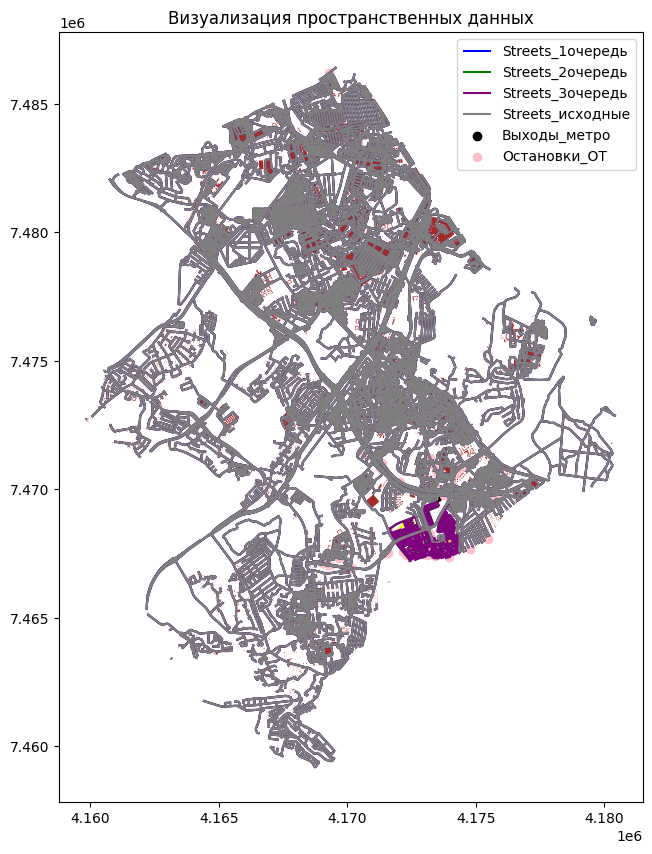

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Пути к данным
file_paths = {
    "House_1очередь_ЖК": r"Векторные данные\House_1очередь_ЖК.shx",
    "House_2очередь_ЖК": r"Векторные данные\House_2очередь_ЖК.shx",
    "House_3очередь_ЖК": r"Векторные данные\House_3очередь_ЖК.shx",
    "Streets_1очередь": r"Векторные данные\Streets_1очередь.shx",
    "Streets_2очередь": r"Векторные данные\Streets_2очередь.shx",
    "Streets_3очередь": r"Векторные данные\Streets_3очередь.shx",
    "Streets_исходные": r"Векторные данные\Streets_исходные.shx",
    "Выходы_метро": r"Векторные данные\Выходы_метро.shx",
    "Дома_исходные": r"Векторные данные\Дома_исходные.shx",
    "Остановки_ОТ": r"Векторные данные\Остановки_ОТ.shx"
}

# Цвета для различных слоев
colors = {
    "House_1очередь_ЖК": "red",
    "House_2очередь_ЖК": "orange",
    "House_3очередь_ЖК": "yellow",
    "Streets_1очередь": "blue",
    "Streets_2очередь": "green",
    "Streets_3очередь": "purple",
    "Streets_исходные": "gray",
    "Выходы_метро": "black",
    "Дома_исходные": "brown",
    "Остановки_ОТ": "pink"
}

# Визуализация данных
fig, ax = plt.subplots(figsize=(12, 10))

for layer, path in file_paths.items():
    data = gpd.read_file(path)
    data.plot(ax=ax, color=colors[layer], label=layer)

plt.legend(loc="upper right")
plt.title("Визуализация пространственных данных")
plt.show()


In [125]:
geo_data = gpd.read_file(r"Векторные данные\Выходы_метро.shx")
geo_data.columns


Index(['Number', 'Text', 'geometry'], dtype='object')

In [123]:
from utils.constants import poi_type, poi_purpose
streets = set(geo_data["Type"].to_list())
#purposes = set(geo_data["Type", "Purpose"].to_list())
types = geo_data[geo_data["Type"].isin(poi_type)]
purposes = geo_data[geo_data["Purpose"].isin(poi_purpose)]
filtered_houses = set(zip(types["Type"], purposes["Purpose"]))
print(filtered_houses)

# # Преобразуем filtered_houses в два списка для удобства
# types_filtered, purposes_filtered = zip(*filtered_houses)

# # Фильтрация строк, где (Type, Purpose) содержатся в filtered_houses
# filtered_rows = geo_data[geo_data.apply(lambda row: (row['Type'], row['Purpose']) in filtered_houses, axis=1)]

# # Подсчёт количества строк
# count_filtered_rows = filtered_rows.shape[0]

# # Вывод результата
# print(f"Количество строк, соответствующих фильтрам: {count_filtered_rows}")
#apartments = geo_data[geo_data["Street"]=="Василия Ощепкова"]

#print(apartments["Apartments"].sum())

{('Жилые дома', 'Школа'), ('Жилые дома', 'Магазин'), ('Жилые дома', 'Техникум, училище'), ('Жилые дома', 'Бизнес-центр'), ('Жилые дома', 'Торговый павильон'), ('Жилые дома', 'Административное здание'), ('Жилые дома', 'Государственное учреждение'), ('Жилые дома', 'Торгово-развлекательный комплекс'), ('Жилые дома', 'Вокзал'), ('Жилые дома', 'Супермаркет'), ('Жилые дома', 'Медицинское учреждение'), ('Жилые дома', 'Гипермаркет'), ('Жилые дома', 'Торговый центр')}


In [90]:
len_before = len(geo_data)
not_null_elevation = geo_data[geo_data['Elevation'].notna()]
len_after = len(not_null_elevation)
print(len_before, len_after)

16386 16385


In [ ]:
import numpy as np

# Загрузка данных
houses = gpd.read_file(r"Векторные данные\Дома_исходные.shx")

# Проверка наличия нужных столбцов
if 'Apartments' in houses.columns and 'Elevation' in houses.columns and 'Type' in houses.columns:
    # Фильтрация данных по нужным типам зданий
    houses_filtered = houses[houses['Type'].isin(['Дома_новостройки', 'Частные дома', 'Жилые дома'])]
    
    # Рассчитываем среднее количество квартир на этаж для типов зданий, кроме "Частных домов"
    known_apartments = houses_filtered[
        (houses_filtered['Apartments'].notna()) &
        (houses_filtered['Elevation'].notna()) &
        (houses_filtered['Type'] != 'Частные дома')
    ]
    known_apartments['Apartments_per_floor'] = known_apartments['Apartments'] / known_apartments['Elevation']
    avg_apartments_per_floor = known_apartments['Apartments_per_floor'].mean()
    
    # Функция для заполнения пропусков в зависимости от типа здания
    def fill_apartments(row):
        if np.isnan(row['Apartments']):  # Если значение пропущено
            if row['Type'] == 'Частные дома':
                return 1  # Для частных домов ставим 1
            elif row['Type'] in ['Дома_новостройки', 'Жилые дома'] and not np.isnan(row['Elevation']):
                return avg_apartments_per_floor * row['Elevation']  # Для остальных типов используем среднее количество квартир на этаж
        return row['Apartments']  # Если значение не пропущено, оставляем его

    # Применяем функцию для заполнения пропусков
    houses['Apartments'] = houses.apply(fill_apartments, axis=1)

else:
    print("В данных отсутствуют необходимые столбцы 'Apartments', 'Elevation' или 'Type'.")

d:\desctop\00myProjects\ЦП_МЕЖНАР\ai_roads\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning:

Векторные данные\Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.

d:\desctop\00myProjects\ЦП_МЕЖНАР\ai_roads\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Type,Caption,Purpose,PostIndex,Elevation,Entrances,Apartments,District,DistrictId,...,StreetId2,Number2,Street3,StreetId3,Number3,Street4,StreetId4,Number4,Material,geometry
16381,None,Киоски,None,Киоск,142704,1.0,NaN,NaN,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Металл,"POLYGON ((4172368.26 7479417.74, 4172365.38 74..."
16382,None,Киоски,None,Киоск,108814,1.0,NaN,NaN,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Металл,"POLYGON ((4172512.69 7472711.19, 4172510.76 74..."
16383,None,Киоски,None,Киоск,108802,1.0,NaN,NaN,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Металл,"POLYGON ((4170835.02 7478501.1, 4170836.5 7478..."
16384,None,Киоски,None,Киоск,142704,1.0,NaN,NaN,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Металл,"POLYGON ((4171461.36 7479576.22, 4171463.29 74..."
16385,None,Административные сооружения,None,Административное здание,None,NaN,NaN,NaN,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,None,"POLYGON ((4173794.898 7468026.28, 4173829.912 ..."
